<a href="https://www.kaggle.com/code/stpeteishii/gym-ant-v4-cip?scriptVersionId=226094955" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Gym Ant-v4 CIP（Causal Information Prioritization）

https://arxiv.org/abs/2502.10097



In [1]:
!pip install gymnasium[mujoco]
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 10.9 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [3]:
class CIPPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, *args, **kwargs):
        super().__init__(observation_space, action_space, lr_schedule, *args, **kwargs)
        
        # Get the dimension of the observation space
        obs_dim = observation_space.shape[0]  # 26 dimensions
        
        # Select an embed_dim that is a divisor of 26 or close to 26
        embed_dim = 26  
        
        self.causal_attention = nn.MultiheadAttention(
            embed_dim=embed_dim, 
            num_heads=2  # Since 26 is divisible by 2
        )
        
        # Projection layer with explicit type conversion
        self.obs_projection = nn.Sequential(
            nn.Linear(obs_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )
        
        # Projection layer to restore features from embedding space
        self.causal_projection = nn.Sequential(
            nn.Linear(embed_dim, obs_dim),
            nn.LayerNorm(obs_dim)
        )

    def forward(self, obs, deterministic=False):
        # Explicitly perform type conversion
        obs = obs.float()
        
        # Project observation into embedding space
        embedded_obs = self.obs_projection(obs)
        
        # Apply causal attention mechanism
        causal_features, _ = self.causal_attention(
            embedded_obs.unsqueeze(0), 
            embedded_obs.unsqueeze(0), 
            embedded_obs.unsqueeze(0)
        )
        causal_features = causal_features.squeeze(0)
        
        # Restore original dimensions
        enhanced_features = self.causal_projection(causal_features)
        
        # Use in PPO's policy and value function computation
        return super().forward(enhanced_features, deterministic)


def create_cip_ppo_model(env, learning_rate=3e-4):
    """
    Create a PPO model integrated with CIP
    
    Args:
        env (gym.Env): Reinforcement learning environment
        learning_rate (float): Learning rate
    
    Returns:
        PPO: CIP-extended PPO model
    """
    policy_kwargs = {
        'net_arch': [dict(pi=[64, 64], vf=[64, 64])]
    }
    
    model = PPO(
        policy=CIPPolicy, 
        env=env, 
        learning_rate=learning_rate,
        policy_kwargs=policy_kwargs,
        verbose=1
    )
    return model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env = gym.make("Ant-v4")
model = create_cip_ppo_model(env)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/policies.py:460: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 63.8     |
|    ep_rew_mean     | -67.9    |
| time/              |          |
|    fps             | 897      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 82.2        |
|    ep_rew_mean          | -89.7       |
| time/                   |             |
|    fps                  | 749         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012302654 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -0.00238    |
|    learning_rate        | 0.

    env = gym.make("Ant-v4")
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

In [5]:
def create_ant_animation(obss):
    """
    Animation connecting points 2, 3, and 4 to point 1 as 1-2, 1-3, 1-4.
    """
    joint_positions = []
    for obs in obss:
        joint_pos = obs[:8]  # Extract position data
        joint_positions.append(joint_pos)
    
    # Prepare the animation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_title('Ant Movement - Radial Joints')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    # Line to track movement trace
    trace, = ax.plot([], [], 'b-', alpha=0.3, label='Movement Trace')
    lines = [ax.plot([], [], 'ro-', lw=2)[0] for _ in range(3)]
    
    # Data for the trace
    x_trace = []
    y_trace = []
    
    def update(frame):
        current_pos = joint_positions[frame]
        
        # Coordinates of the center point and other points
        center_x, center_y = current_pos[0], current_pos[1]
        point2_x, point2_y = current_pos[2], current_pos[3]
        point3_x, point3_y = current_pos[4], current_pos[5]
        point4_x, point4_y = current_pos[6], current_pos[7]
        
        # Three lines (1-2, 1-3, 1-4)
        lines[0].set_data([center_x, point2_x], [center_y, point2_y])
        lines[1].set_data([center_x, point3_x], [center_y, point3_y])
        lines[2].set_data([center_x, point4_x], [center_y, point4_y])
        
        # Update the trace
        x_trace.append(center_x)
        y_trace.append(center_y)
        trace.set_data(x_trace, y_trace)
        
        return lines + [trace]
    
    # Create the animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(joint_positions), 
        interval=50,  # Update frame every 50 milliseconds
        blit=True,
        repeat=False  # Play animation only once
    )
    
    # Add legend
    plt.legend()
    
    # Save the animation
    anim.save('ant_movement.gif', writer='pillow')
    
    plt.close(fig)
    print("Saved radial joint connection animation as 'ant_movement.gif'.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Create evaluation environment
eval_env = gym.make("Ant-v4", render_mode="rgb_array")

try:
    # Reset to initial state
    obs, info = eval_env.reset(seed=42)
    
    # Collect observation data
    episode_obss = [obs]
    rewards=[]
    
    for _ in range(200):  # Up to 200 steps
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = eval_env.step(action)
        episode_obss.append(obs)
        rewards+=[reward]
        
        if done or truncated:
            break
    
    # Create animation
    create_ant_animation(episode_obss)

except Exception as e:
    print(f"Error: {e}")
finally:
    eval_env.close()

Saved radial joint connection animation as 'ant_movement.gif'.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


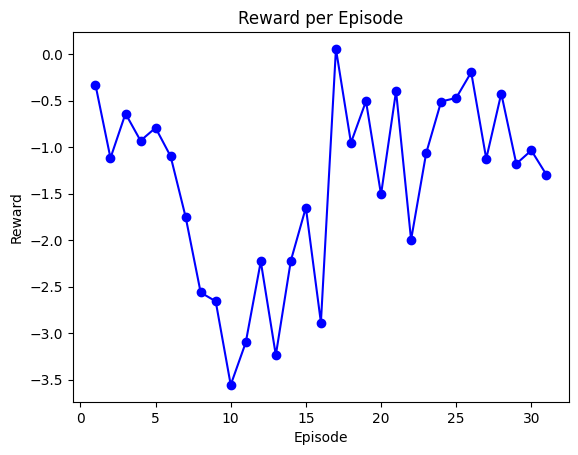

In [7]:
import matplotlib.pyplot as plt

episodes = list(range(1, len(rewards) + 1))

plt.plot(episodes, rewards, marker='o', linestyle='-', color='b')

plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.show()

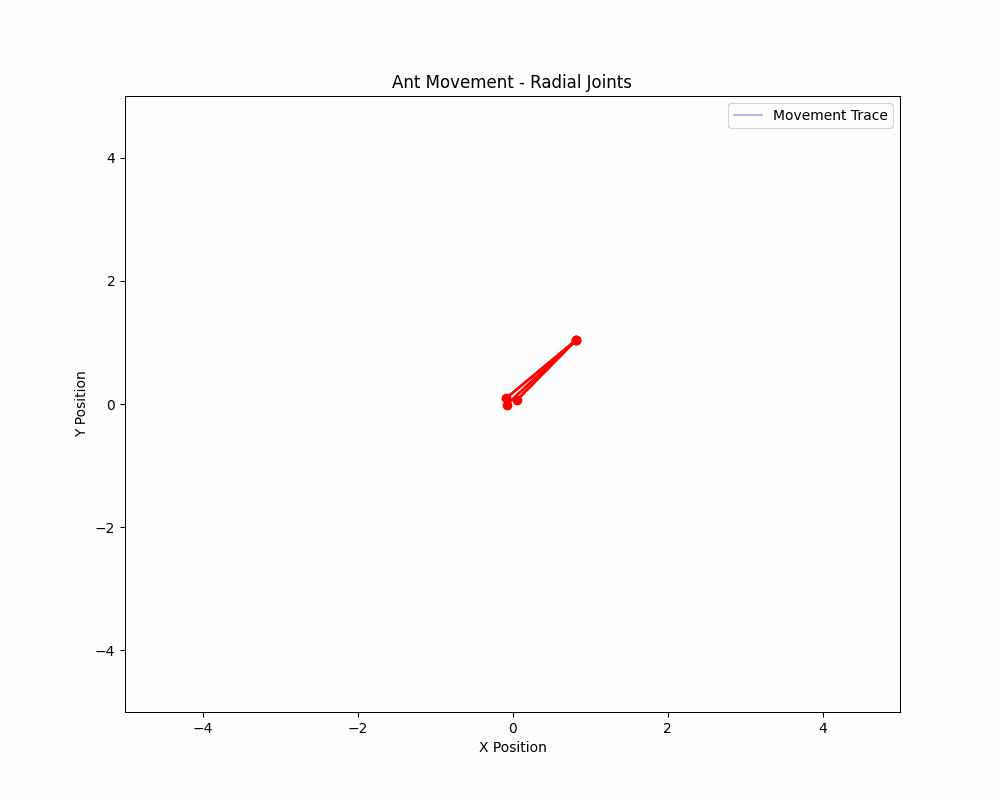

In [8]:
from IPython.display import Image
Image(open('./ant_movement.gif','rb').read())